In [1]:
from scipy.sparse import diags #linalg
from scipy.linalg import solve
import numpy as np

In [2]:
def solver(T,dt,L1, L2, L3):
    N = int(round(T/dt))
    t = np.linspace(0,T,N+1) #time discrete
    M = int(round(L/dx))
    x = np.linspace(0,L,M+1) #space discrete
    E = np.zeros((M+1,N+1))
    S = np.zeros((M+1,N+1))
    C = np.zeros((M+1,N+1))
    PPX = np.zeros((M+1))
    Em_E = np.zeros((M+1,N+1))
    B = np.zeros((M+1))
    RHS = np.zeros((M+1))
    
    #initial conditions
    S[0,0] = 1
    C[0,0] = 0.8
    E[0,0] = p*den*h*S[0,0]+p*h*den*theta*C[0,0]
    B[0] = Q*S[0,0]  #boundary condition
    Em_E[0,0] = 0.55556
    
    #special time step at n=0
    L11 = np.multiply(L1,Em_E[0:M+1,0])
    PPX[:] = np.dot(QP, Em_E[0:M+1,0])
    PPX[PPX<0]=0 
    L22 = np.multiply(L2,PPX[:])
    L33 = np.multiply(L3, Em_E[0:M+1,0])
    M1 = Z / dt + w1 * (L11 + L22 + L33)
    E[:,1] = np.linalg.solve(M1, B)
    S[:,1] = E[:,1] / (den*p*h+0.8*p*h*den*theta)
    C[:,1] = 0.8 * S[:,1]
    
    
    for n in range(1,N):
        #update all matrices
        Em_E[0:M+1,n] = np.divide(E[0:M+1,n]-p*h*den*theta*C[0:M+1,n], E[0:M+1,n],out=np.zeros_like(E[0:M+1,n]-p*h*den*theta*C[0:M+1,n]), where=E[0:M+1,n]!=0)
        L11 = np.multiply(L1,Em_E[0:M+1,n])
        PPX[:] = np.dot(QP, Em_E[0:M+1,n])
        PPX[PPX<0]=0 
        L22 = np.multiply(L2,PPX[:])
        L33 = np.multiply(L3, Em_E[0:M+1,n])
        M1 = Z / dt + w1 * (L11 + L22 + L33)
        M2 = Z / dt - w2 * (L11 + L22 + L33)
        RHS[:] = M2.dot(E[:,n]) + B
        E[:,n+1] = np.linalg.solve(M1, RHS)
        S[:,n+1] = E[:,n+1] / (den*p*h+0.8*p*h*den*theta)
        C[:,n+1] = 0.8 * S[:,n+1]
        
    return   S, x, t



In [16]:
from scipy.integrate import quad
#Solving for matrices L1, L2, L3
T = 1800
L = 50000
wd = 10         #width
h = 5           #height
fv = 0.4        #flow velocity
sg = 1          #specific gravity
den = 0.01      #density of CIMW and CMW
p = 2*h+wd      #wetted perimeter
theta = 1       #porosity
l = 50          #element distance
Q = 20          #flow rate
K = 25        #dispersion coefficient K=diffusion+dispersitivity*fv
A = 50          #Area
dt = 180         #time step size
dx = 50
w1 = 1          #weight
w2 = 0
N = int(round(T/dt))          #no. of time steps
M = int(round(L/dx))          #no. of nodes

#Solving for L1, let E=E^m/E (to be solve)
def integrand(x):
    return -(-1/l)*Q*(1-x/l)
ans1, err = quad(integrand, 0, l)

def integrand(x):
    return -(-1/l)*Q*(x/l)
ans2, err = quad(integrand, 0, l)

def integrand(x):
    return -(1/l)*Q*(1-x/l)
ans3, err = quad(integrand, 0, l)

def integrand(x):
    return -(1/l)*Q*(x/l)
ans4, err = quad(integrand, 0, l)

L1 = diags([ans3,(int(ans1)+ans4),int(ans2)], [-1,0,1], shape=(M+1, M+1)).toarray()
L1[0, 0] = int(ans1)
L1[M, M] = ans4
#matrix multiply L1 with vector Em/E

#Solving QP1

def integrand(x):
    return (1-x/l)*(1-x/l)
ans5, err = quad(integrand, 0, l)

def integrand(x):
    return (1-x/l)*(x/l)
ans6, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*(x/l)
ans7, err = quad(integrand, 0, l)

QP1_11 = ans5
QP1_12 = ans6
QP1_21 = ans6
QP1_22 = ans7

#QP1 Lump Matrix
QP11 = ans5+ans6
QP22 = (ans5+2*ans6+ans7)*np.ones(M+1)
QP21 = ans6+ans7
QP1 = np.zeros((M+1)**2).reshape(M+1, M+1)+np.diag(QP22, 0)
QP1[0, 0] = QP11
QP1[M, M] = QP21

#Solving for QP2

def integrand(x):
    return (1-x/l)*(-1/l)
ans8, err = quad(integrand, 0, l)

def integrand(x):
    return (1-x/l)*(1/l)
ans9, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*(-1/l)
ans10, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*(1/l)
ans11, err = quad(integrand, 0, l)

QP2_11 = ans8
QP2_12 = ans9
QP2_21 = ans10
QP2_22 = ans11

#Matrix QP
QP_11 = QP2_11/(ans5+2*ans6+ans7)
QP_12 = QP2_12/(ans5+2*ans6+ans7)
QP_21 = QP2_21/(ans5+2*ans6+ans7)
QP_22 = QP2_22/(ans5+2*ans6+ans7)
qp1 = (QP_11+QP_22)*np.ones(M+1)
qp2 = (QP_12)*np.ones(M)
qp3 = (QP_21)*np.ones(M)
QP = np.zeros((M+1)**2).reshape(M+1,M+1)+np.diag(qp1,0)+np.diag(qp2,1)++np.diag(qp3,-1)
QP[0,0] = QP2_11/QP11
QP[0,1] = QP2_12/QP11
QP[M,M] = QP2_21/QP21
QP[M,M] = QP2_22/QP21

#To solve PPX, matrix multiply with Em/E
#Solve for Em/E for each time step and update it

#Solving for L2

def integrand(x):
    return (-1/l)*K*A*(1-x/l)
ans12, err = quad(integrand, 0, l)

def integrand(x):
    return (-1/l)*K*A*(x/l)
ans13, err = quad(integrand, 0, l)

def integrand(x):
    return (1/l)*K*A*(1-x/l)
ans14, err = quad(integrand, 0, l)

def integrand(x):
    return (1/l)*K*A*(x/l)
ans15, err = quad(integrand, 0, l)

L2 = diags([ans14,(ans12+ans15),ans13], [-1,0,1], shape=(M+1, M+1)).toarray()
L2[0,0] = ans12
L2[M,M] = ans15
#Finally L2 = L2*PPX

#Solving for L3

def integrand(x):
    return (-1/l)*K*A*(-1/l)
ans16, err = quad(integrand, 0, l)

def integrand(x):
    return (-1/l)*K*A*(1/l)
ans17, err = quad(integrand, 0, l)

def integrand(x):
    return (1/l)*K*A*(-1/l)
ans18, err = quad(integrand, 0, l)

def integrand(x):
    return (1/l)*K*A*(1/l)
ans19, err = quad(integrand, 0, l)

L3 = diags([ans18,(ans16+ans19),ans17], [-1,0,1], shape=(M+1, M+1)).toarray()
L3[0,0] = ans16
L3[M,M] = ans19
#finally L3 = L3*Em/E

#Solving for M

def integrand(x):
    return (1-x/l)*A*(1-x/l)
ans20, err = quad(integrand, 0, l)

def integrand(x):
    return (1-x/l)*A*(x/l)
ans21, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*A*(1-x/l)
ans22, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*A*(x/l)
ans23, err = quad(integrand, 0, l)

Z = diags([ans22,(ans20+ans23),ans21], [-1,0,1], shape=(M+1, M+1)).toarray()
Z[0, 0] = ans20
Z[M, M] = ans23

(S,x,t) = solver(T,dt,L1, L2, L3)



In [11]:
from matplotlib import pyplot as plt

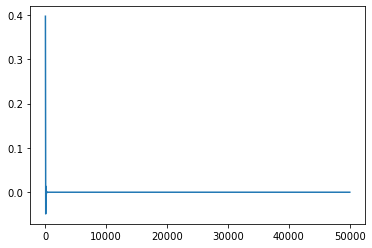

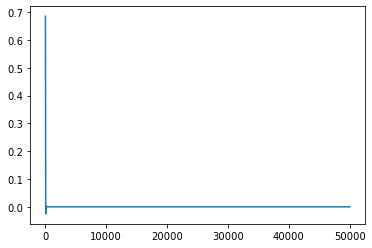

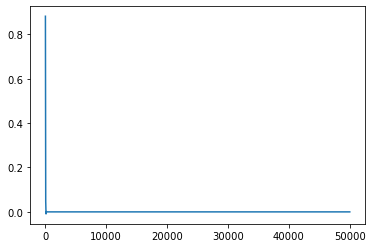

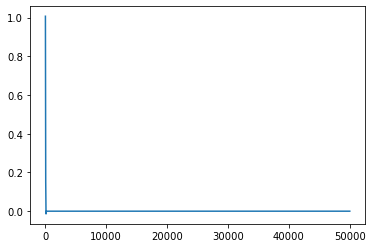

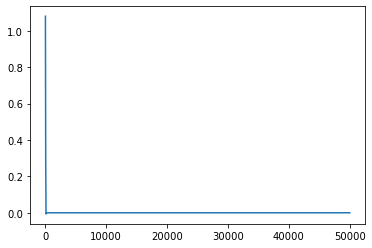

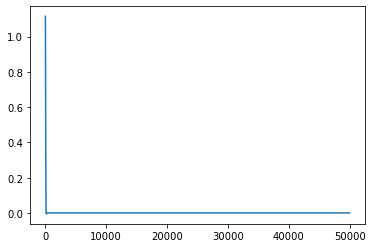

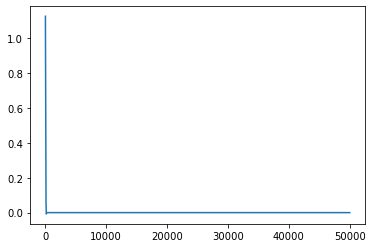

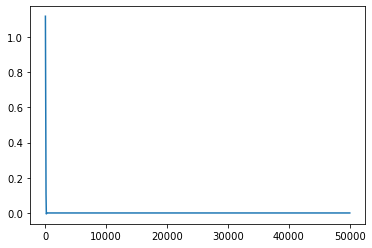

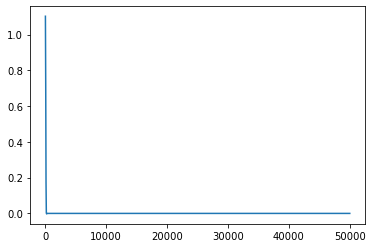

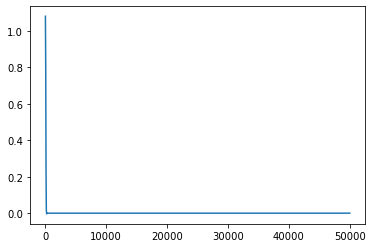

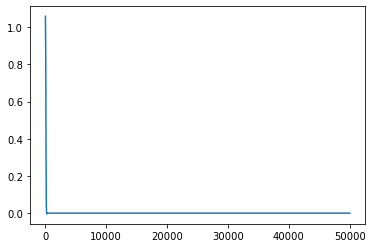

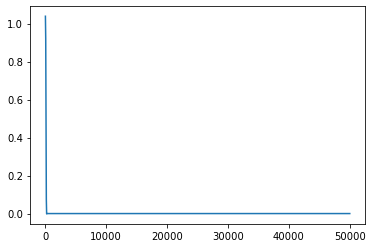

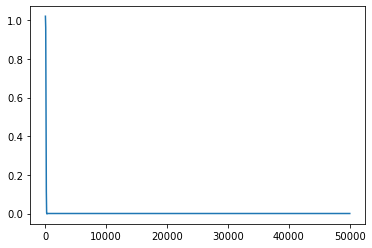

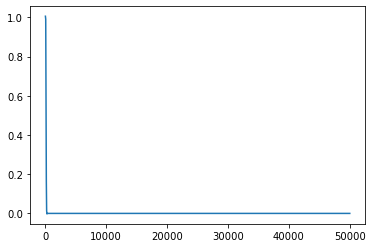

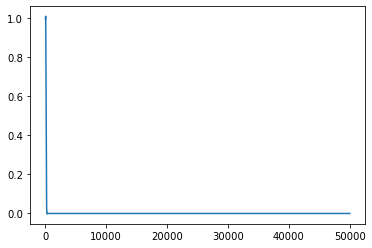

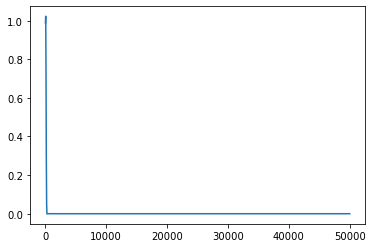

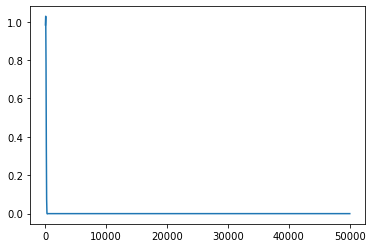

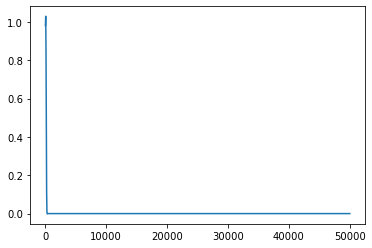

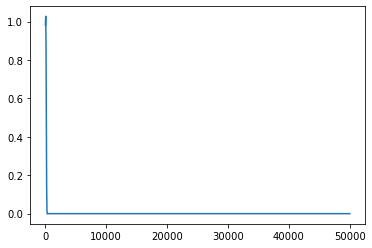

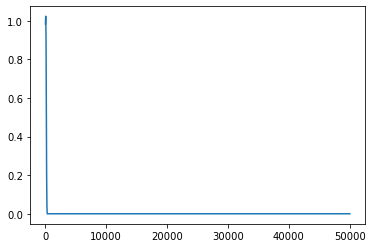

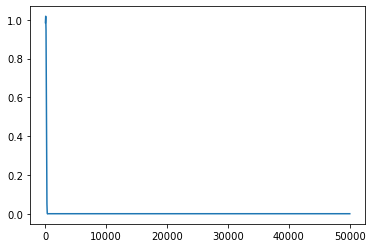

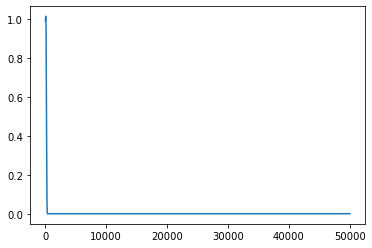

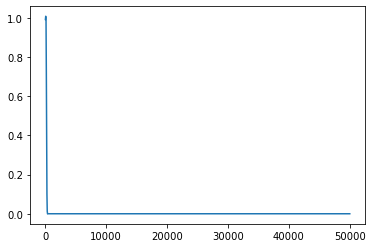

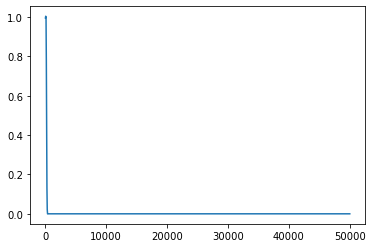

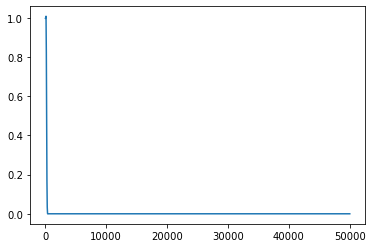

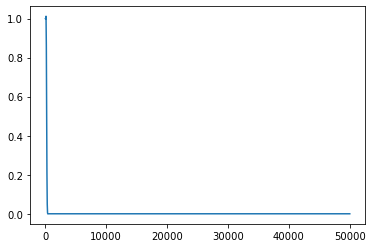

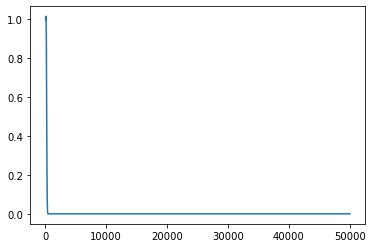

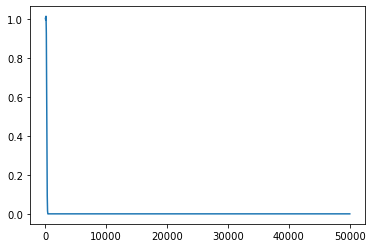

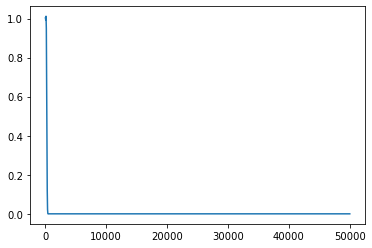

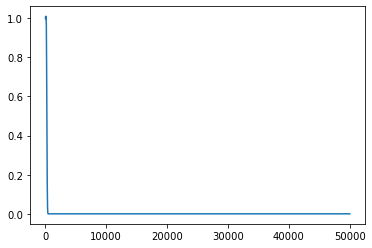

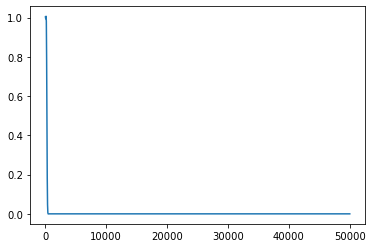

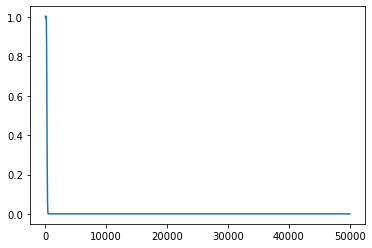

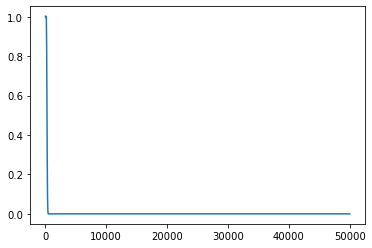

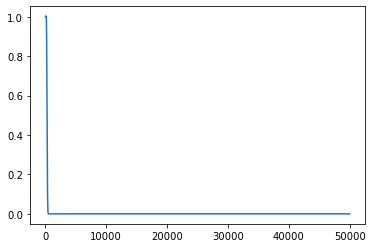

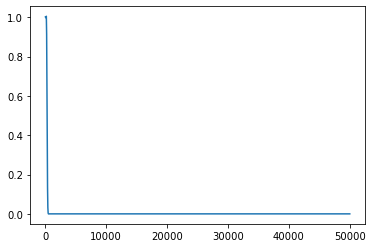

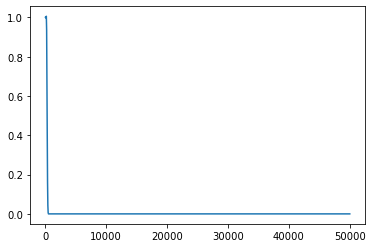

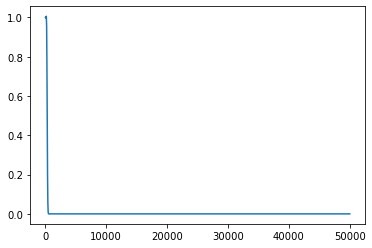

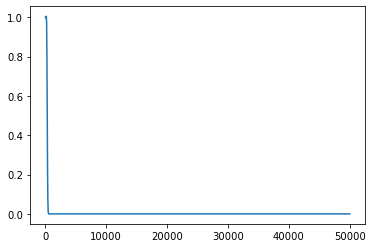

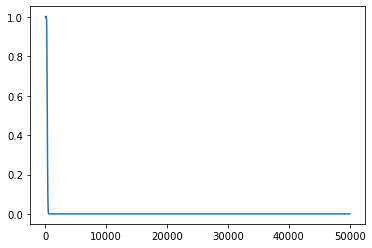

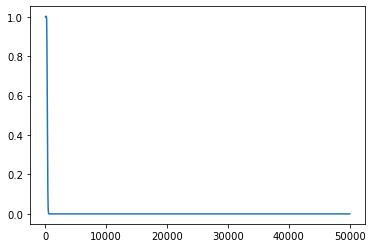

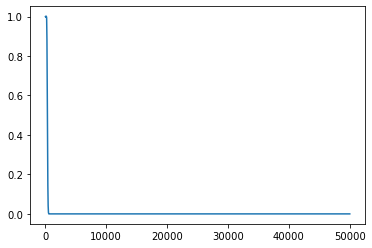

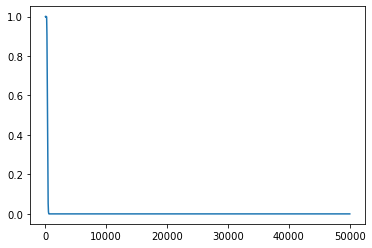

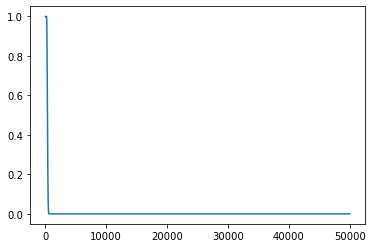

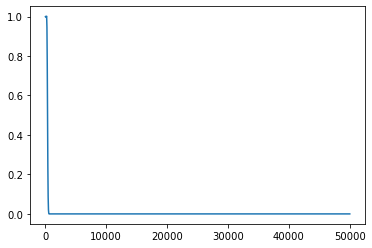

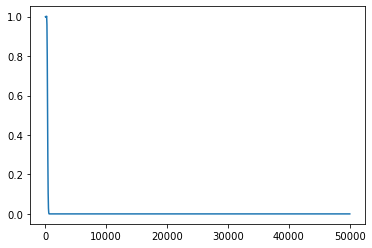

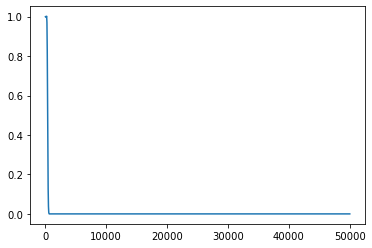

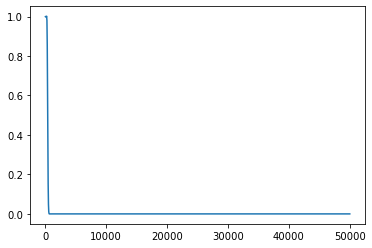

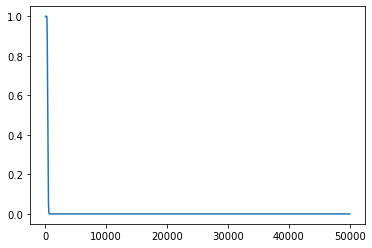

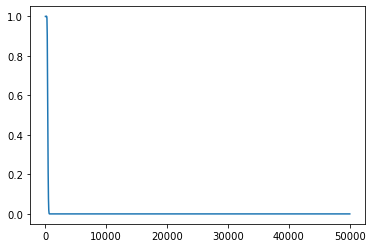

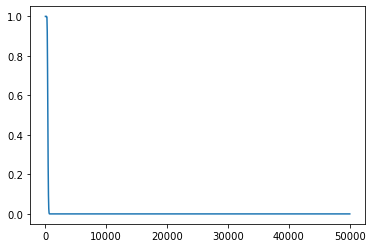

IndexError: index 51 is out of bounds for axis 1 with size 51

In [5]:
t = np.linspace(0,T,N+1)
for n in range(len(t)):
    #plt.plot(x,S[:,1])
    plt.plot(x,S[:,n+1])
    plt.show()

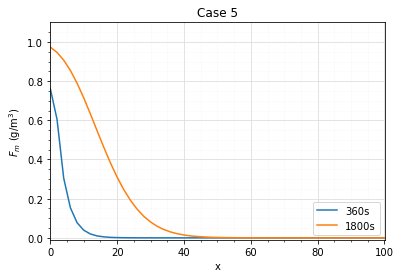

In [17]:
fig, ax = plt.subplots()
ax.axis([-0.1,100+0.1,-0.01,1.1]) 
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

plt.plot(x/25,S[:,2])
plt.plot(x/25,S[:,N])
plt.legend(["360s","1800s"], loc ="lower right")
plt.xlabel("x")
plt.ylabel("$F_m$ (g/m$^3$)")
plt.title("Case 5")
plt.savefig('Example 1 Case 5.png')

plt.show()

In [10]:
from matplotlib import animation as animation
from IPython.display import HTML

In [11]:
#fig = plt.figure()
fig, ax = plt.subplots()
ax.axis([-0.1,100+0.1,-0.01,1.1]) 
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

plt.rcParams['figure.figsize'] = (5,3)
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript


def initpict():
    x = np.linspace(0, L, M+1)
    line.set_data(x/25,S[:,0])

line, = plt.plot([ ], [ ], lw=3) 

def redraw(i):
    x = np.linspace(0, L, M+1)
    line.set_data(x/25, S[:,i])

anim = animation.FuncAnimation(fig, redraw, init_func=initpict, frames=len(t), interval=100)
fig.suptitle('Case 3 Option 1', fontsize=14)

plt.close()
anim